# TRAINING

Using device: cuda
Dataset reorganized and split into train/val sets.
Classes: ['Normal', 'Early Cancer', 'Advanced Cancer']
Number of classes: 3


c:\Users\Liver - Sagar\Desktop\SIDEGIG\senv11\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Liver - Sagar\Desktop\SIDEGIG\senv11\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training on raw images...
Epoch 1/10
----------
train Loss: 0.4893 Acc: 0.7922
val Loss: 0.3577 Acc: 0.8550

Epoch 2/10
----------
train Loss: 0.3439 Acc: 0.8565
val Loss: 0.3098 Acc: 0.8731

Epoch 3/10
----------
train Loss: 0.3127 Acc: 0.8711
val Loss: 0.2982 Acc: 0.8894

Epoch 4/10
----------
train Loss: 0.3081 Acc: 0.8712
val Loss: 0.3157 Acc: 0.8756

Epoch 5/10
----------
train Loss: 0.2863 Acc: 0.8808
val Loss: 0.2555 Acc: 0.8956

Epoch 6/10
----------
train Loss: 0.2729 Acc: 0.8875
val Loss: 0.3006 Acc: 0.8694

Epoch 7/10
----------
train Loss: 0.2789 Acc: 0.8867
val Loss: 0.2683 Acc: 0.8944

Epoch 8/10
----------
train Loss: 0.2540 Acc: 0.8923
val Loss: 0.2510 Acc: 0.8988

Epoch 9/10
----------
train Loss: 0.2488 Acc: 0.8942
val Loss: 0.2460 Acc: 0.8919

Epoch 10/10
----------
train Loss: 0.2441 Acc: 0.8998
val Loss: 0.2463 Acc: 0.8962

Training completed in 8.17 minutes
Model saved as 'esophageal_classifier_kvasir_v2_cnn.pth'
Validation Accuracy: 0.8988


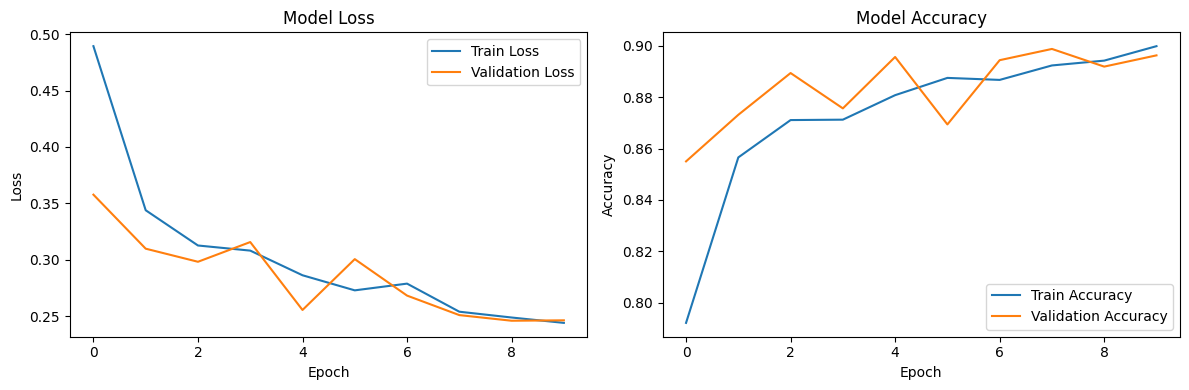

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
import shutil
import random
from sklearn.model_selection import train_test_split
import time
import copy
import matplotlib.pyplot as plt

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Define class mapping for esophageal cancer detection
class_mapping = {
    'normal-cecum': 'Normal',
    'normal-pylorus': 'Normal',
    'normal-z-line': 'Normal',
    'esophagitis': 'Early Cancer',  # Esophagitis as a precursor or early stage
    'dyed-lifted-polyps': 'Advanced Cancer',
    'polyps': 'Advanced Cancer',  # Polyps as potential advanced lesions
    'ulcerative-colitis': 'Advanced Cancer',  # Severe pathology mapped to advanced cancer
    'dyed-resection-margins': 'Advanced Cancer'  # Post-treatment or severe lesions
}

# 2. Function to reorganize dataset based on class mapping
def reorganize_dataset(source_dir, target_dir, train_ratio=0.8):
    if not os.path.exists(target_dir):
        os.makedirs(os.path.join(target_dir, 'train'))
        os.makedirs(os.path.join(target_dir, 'val'))

    for folder in os.listdir(source_dir):
        if folder in class_mapping:
            source_path = os.path.join(source_dir, folder)
            images = [f for f in os.listdir(source_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            random.shuffle(images)
            
            # Split into train and validation
            train_size = int(len(images) * train_ratio)
            train_images = images[:train_size]
            val_images = images[train_size:]

            # Create target directories for mapped class
            mapped_class = class_mapping[folder]
            for phase in ['train', 'val']:
                os.makedirs(os.path.join(target_dir, phase, mapped_class), exist_ok=True)

            # Move train images
            for img in train_images:
                src = os.path.join(source_path, img)
                dst = os.path.join(target_dir, 'train', mapped_class, img)
                shutil.copy(src, dst)

            # Move validation images
            for img in val_images:
                src = os.path.join(source_path, img)
                dst = os.path.join(target_dir, 'val', mapped_class, img)
                shutil.copy(src, dst)

    print("Dataset reorganized and split into train/val sets.")

# Reorganize your dataset (run this once)
source_dir = r'C:\Users\Liver - Sagar\Desktop\SIDEGIG\anjali\kvasir-dataset-v2\kvasir-dataset-v2'  # Replace with your exact path
target_dir = 'kvasir_v2_reorganized'  # Where to save reorganized data (create this directory)
reorganize_dataset(source_dir, target_dir)

# 3. Define data transforms for the reorganized dataset (for raw images)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet50 expects 224x224
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 4. Load the reorganized dataset (raw images)
data_dir = target_dir  # Use the reorganized dataset path
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
}

# Create data loaders for raw images
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = ['Normal', 'Early Cancer', 'Advanced Cancer']  # Updated based on mapping
num_classes = len(class_names)
print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")

# 5. Load and modify ResNet50 (CNN) for raw images
model = models.resnet50(pretrained=True)

# Freeze all layers except the final fully connected layer
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer for your number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# 6. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)  # Optimize only the final layer initially

# Optionally, schedule learning rate decay
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 7. Training and validation function for raw images
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimize (only in training phase)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store history for plotting
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Deep copy the model if best accuracy on validation
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# 8. Train the model on raw images
print("Starting training on raw images...")
start_time = time.time()

model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=10)

end_time = time.time()
print(f"Training completed in {((end_time - start_time) / 60):.2f} minutes")

# 9. Save the model
torch.save(model.state_dict(), 'esophageal_classifier_kvasir_v2_cnn.pth')
print("Model saved as 'esophageal_classifier_kvasir_v2_cnn.pth'")

# 10. Evaluate on a validation set
def evaluate_model(model, dataloader):
    model.eval()
    running_corrects = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)

    accuracy = running_corrects.double() / total
    print(f'Validation Accuracy: {accuracy:.4f}')

evaluate_model(model, dataloaders['val'])

# 11. Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history_cnn.png')
    plt.show()

plot_training_history(history)

# TESTING

Using device: cuda
CUDA Device Name: NVIDIA RTX A4000 Laptop GPU


c:\Users\Liver - Sagar\Desktop\SIDEGIG\senv11\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Liver - Sagar\Desktop\SIDEGIG\senv11\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Image 1: 00072d5f-7cd8-434c-8a5a-1a0bb2c9711d.jpg
  True Class: Normal
  Predicted Class: Normal
  Confidence: 0.9956
--------------------------------------------------
Image 2: 0014d89e-5afa-4186-99f9-4400c8c58a18.jpg
  True Class: Normal
  Predicted Class: Normal
  Confidence: 0.9525
--------------------------------------------------
Image 3: 0046dd24-a4c0-4923-a07a-15be898182e2.jpg
  True Class: Normal
  Predicted Class: Normal
  Confidence: 0.8867
--------------------------------------------------
Image 4: 0053d7cd-549c-48cd-b370-b4ad64a8098a.jpg
  True Class: Normal
  Predicted Class: Normal
  Confidence: 0.9996
--------------------------------------------------
Image 5: 0062bbf3-58d7-435d-b0ca-381703c39911.jpg
  True Class: Normal
  Predicted Class: Normal
  Confidence: 0.9875
--------------------------------------------------
Image 6: 006338df-e61e-4725-bb6c-dd0620f11cdc.jpg
  True Class: Normal
  Predicted Class: Normal
  Confidence: 0.8263
-------------------------------------

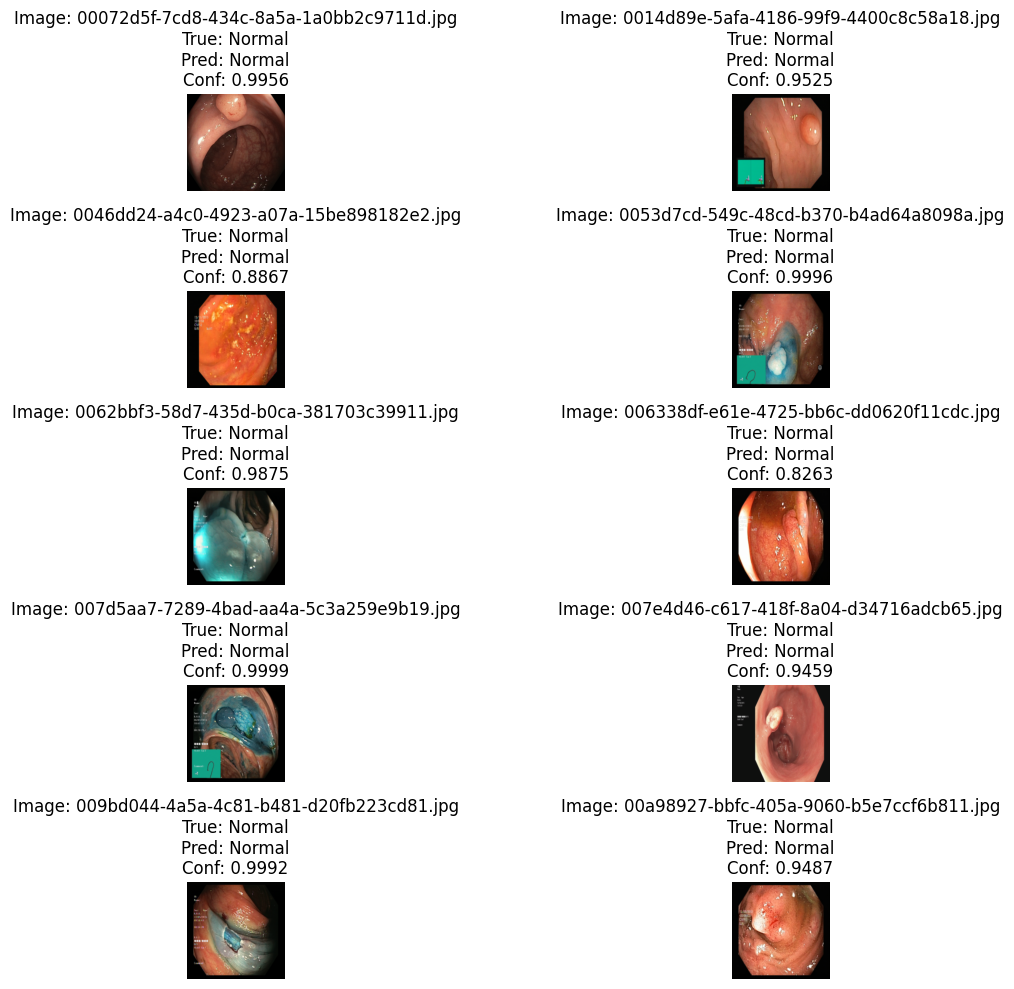


Validation Accuracy: 0.9020

Validation Confusion Matrix:
[[1854    1  101]
 [   7  335  140]
 [  76   59 1347]]

Validation Classification Report:
                 precision    recall  f1-score   support

         Normal       0.96      0.95      0.95      1956
   Early Cancer       0.85      0.70      0.76       482
Advanced Cancer       0.85      0.91      0.88      1482

       accuracy                           0.90      3920
      macro avg       0.88      0.85      0.86      3920
   weighted avg       0.90      0.90      0.90      3920


Predictions saved to 'Validation_predictions.csv'


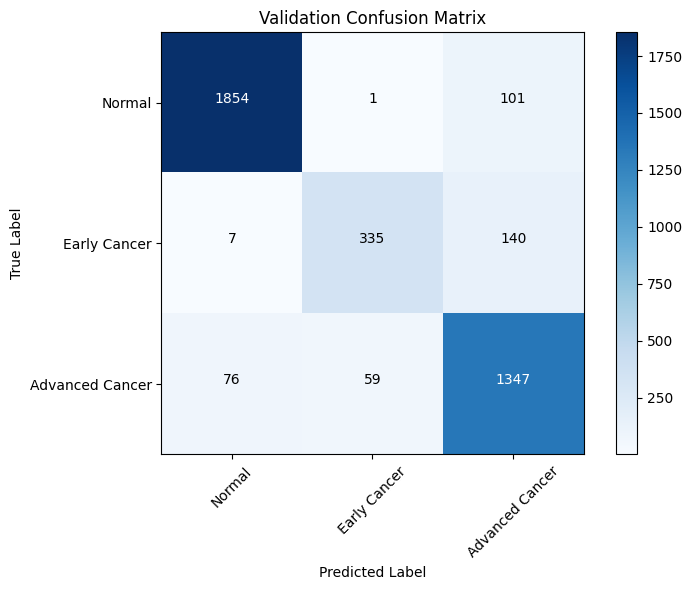

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import os
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import pathlib

# Set device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")

# 1. Define class mapping for esophageal cancer detection
class_mapping = {
    'normal-cecum': 'Normal',
    'normal-pylorus': 'Normal',
    'normal-z-line': 'Normal',
    'esophagitis': 'Early Cancer',
    'dyed-lifted-polyps': 'Advanced Cancer',
    'polyps': 'Advanced Cancer',
    'ulcerative-colitis': 'Advanced Cancer',
    'dyed-resection-margins': 'Advanced Cancer'
}

class_names = ['Normal', 'Early Cancer', 'Advanced Cancer']
class_to_idx = {cls: idx for idx, cls in enumerate(class_names)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

num_classes = len(class_names)

# 2. Define data transforms (same as validation transforms in training)
data_transforms = {
    'val': transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet50 expects 224x224
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet stats
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 3. Load the reorganized dataset (validation set, or test set if available)
data_dir = 'kvasir_v2_reorganized'  # Replace with the path to your reorganized dataset (e.g., C:/Users/Liver - Sagar/Desktop/SIDGEIG/kvasir_v2_reorganized)

# Load validation set
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True if torch.cuda.is_available() else False)  # Batch size of 1 for individual predictions

# Optional: Load test set (uncomment and update path if you have a separate test set)
# test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True if torch.cuda.is_available() else False)

# 4. Load the trained model
model = models.resnet50(pretrained=False)  # Load without pretrained weights
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Reapply the final layer for 3 classes
model.load_state_dict(torch.load('esophageal_classifier_kvasir_v2_cnn.pth'))  # Load your saved model
model = model.to(device)
model.eval()  # Set to evaluation mode

# 5. Evaluate the model and show predictions with images
def evaluate_model_and_show_predictions(model, dataloader, phase='Validation'):
    model.eval()
    all_preds = []
    all_labels = []
    running_corrects = 0
    total = 0
    predictions_list = []  # List to store predictions for each image

    plt.figure(figsize=(15, 5 * 2))  # Adjust figure size for multiple images

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Get prediction and true label for this image
            pred_class = idx_to_class[preds.item()]
            true_class = idx_to_class[labels.item()]
            image_path = val_dataset.imgs[i][0]  # Path to the image
            image_filename = os.path.basename(image_path)
            confidence = torch.softmax(outputs, dim=1)[0][preds].item()  # Confidence score for the predicted class
            predictions_list.append({
                'Image': image_filename,
                'True Class': true_class,
                'Predicted Class': pred_class,
                'Confidence': confidence
            })

            # Display image with prediction (for first 10 images)
            if i < 10:  # Show first 10 predictions with images
                plt.subplot(5, 2, i + 1)  # 5 rows, 2 columns for 10 images
                # Unnormalize and convert tensor back to image for display
                input_image = inputs.cpu().numpy().transpose((0, 2, 3, 1))  # Convert to [batch, H, W, C]
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                input_image = std * input_image + mean  # Unnormalize
                input_image = np.clip(input_image, 0, 1)  # Clip values to [0, 1]
                plt.imshow(input_image[0])  # Display the image
                plt.title(f"Image: {image_filename}\nTrue: {true_class}\nPred: {pred_class}\nConf: {confidence:.4f}")
                plt.axis('off')

            # Print prediction details
            if i < 10:  # Show first 10 predictions as text
                print(f"Image {i + 1}: {image_filename}")
                print(f"  True Class: {true_class}")
                print(f"  Predicted Class: {pred_class}")
                print(f"  Confidence: {confidence:.4f}")
                print("-" * 50)

    plt.tight_layout()
    plt.savefig(f'{phase}_predictions_with_images.png')  # Save all images in one figure
    plt.show()

    accuracy = running_corrects.double() / total
    print(f'\n{phase} Accuracy: {accuracy:.4f}')

    # Compute confusion matrix and classification report
    cm = confusion_matrix(all_labels, all_preds)
    print(f'\n{phase} Confusion Matrix:')
    print(cm)

    print(f'\n{phase} Classification Report:')
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Save predictions to a CSV file for all images
    predictions_df = pd.DataFrame(predictions_list)
    predictions_df.to_csv(f'{phase}_predictions.csv', index=False)
    print(f"\nPredictions saved to '{phase}_predictions.csv'")

    return all_preds, all_labels, cm, predictions_list

# 6. Run evaluation on validation set and show predictions with images
val_preds, val_labels, val_cm, val_predictions = evaluate_model_and_show_predictions(model, val_loader, phase='Validation')

# 7. Optional: Run evaluation on test set (if available)
# If you have a test set, uncomment and run:
# test_preds, test_labels, test_cm, test_predictions = evaluate_model_and_show_predictions(model, test_loader, phase='Test')

# 8. Visualize confusion matrix for validation set
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.savefig(f'{title}.png')
    plt.show()

plot_confusion_matrix(val_cm, class_names, title='Validation Confusion Matrix')

# 9. Optional: Visualize confusion matrix for test set (if available)
# If you have a test set, uncomment and run:
# plot_confusion_matrix(test_cm, class_names, title='Test Confusion Matrix')

In [1]:
import torch
print(torch.cuda.is_available())  # Should print True
print(torch.cuda.device_count())  # Number of GPUs (should be >= 1)
print(torch.cuda.get_device_name(0))  # Name of your GPU

True
1
NVIDIA RTX A4000 Laptop GPU
